## plot_timeheight.ipynb

Author: Robert M. Frost

University of Oklahoma

Created: 09 November 2023

Purpose: Plot timeheight series of supercell updrafts

In [28]:
import matplotlib.pyplot as plt
from matplotlib import rc
import xarray as xr
import pyart
import numpy as np
from matplotlib.ticker import MultipleLocator
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates

In [29]:
elec = "nonlightning"
case_id = "201708-058"

dth = f"/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/Capstone_2023/data/{elec}_cases/timeheight_{case_id}.nc"
figdir = f"/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/figures/{elec}_cases/{case_id}/"
dtrack = f"/Users/robertfrost/Documents/boomsoon/2023_semester_2/capstone/analysis/capstone_2023.nc"

In [30]:
# set melting layer height
if (case_id == "201306-018") or (case_id == "201306-020"):
    melting_layer = 4.5 #(km)
elif case_id == "201708-053":
    melting_layer = 5 #(km)
elif case_id == "201708-058":
    melting_layer = 5.4 #(km)

In [31]:
th = xr.open_dataset(dth)
track = xr.open_dataset(dtrack)
case_meso = track.where(track.mesocyclone_id == th.mesocyclone_id, drop=True)

In [32]:
# Set the font weight for plot titles
plt.rcParams['axes.titleweight'] = 'bold'

# Set the font weight for x-axis and y-axis labels
plt.rcParams['axes.labelweight'] = 'normal'

plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

# Other plotting setup
rc('font', family='serif')
rc('font', weight='normal', size=17.5)
rc('figure', facecolor='white') 

In [33]:
time = th.time
z = th.z
reflectivity = th.reflectivity
differential_reflectivity = th.differential_reflectivity
cross_correlation_ratio = th.cross_correlation_ratio
specific_differential_phase = th.specific_differential_phase

In [34]:
reflectivity_threshhold = 30 # in dbz
high_reflectivity = reflectivity.where(reflectivity > reflectivity_threshhold)
updraft_depth_idx = high_reflectivity.argmin(dim="z")
updraft_depth = th.z[updraft_depth_idx]

### Reflectivity Plot

In [35]:
# colormaps

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

clevs = np.linspace(0.,2.0,20)
colors = ['firebrick','red','darkorange','gold','green','lightgreen','lawngreen','aquamarine', 'cyan', 'deepskyblue','dodgerblue','blue', 'magenta']
#colors = ['white','red','darkorange','gold','green','lightgreen','lawngreen','aquamarine', 'cyan', 'deepskyblue','dodgerblue','blue', 'magenta']
cmap_kdp = ListedColormap(colors)

# set up a CC (rhohv) colormap
cdict = {'red':   [[0.0,  0.0, 0.0],
                    [0.5,  0.0, 0.0],
                    [0.85,  1.0, 1.0],
                    [1.0,  1.0, 1.0]],
            'green': [[0.0,  0.0, 0.0],
                    [0.25, 0.0, 0.0],
                    [0.5,  0.0, 0.0],
                    [0.85,  1.0, 1.0],
                    [1.0,  0.0, 0.0]],
            'blue':  [[0.0,  1.0, 1.0],
                    [0.5,  1.0, 1.0],
                    [1.0,  0.1, 0.1]]}

cc_cmap = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
ticks = np.arange(1,14)
labs = ['L/MR','HR','R/Ha','BD','AP','BI','UK','NE','DS','WS','CY','','GR','+'] 

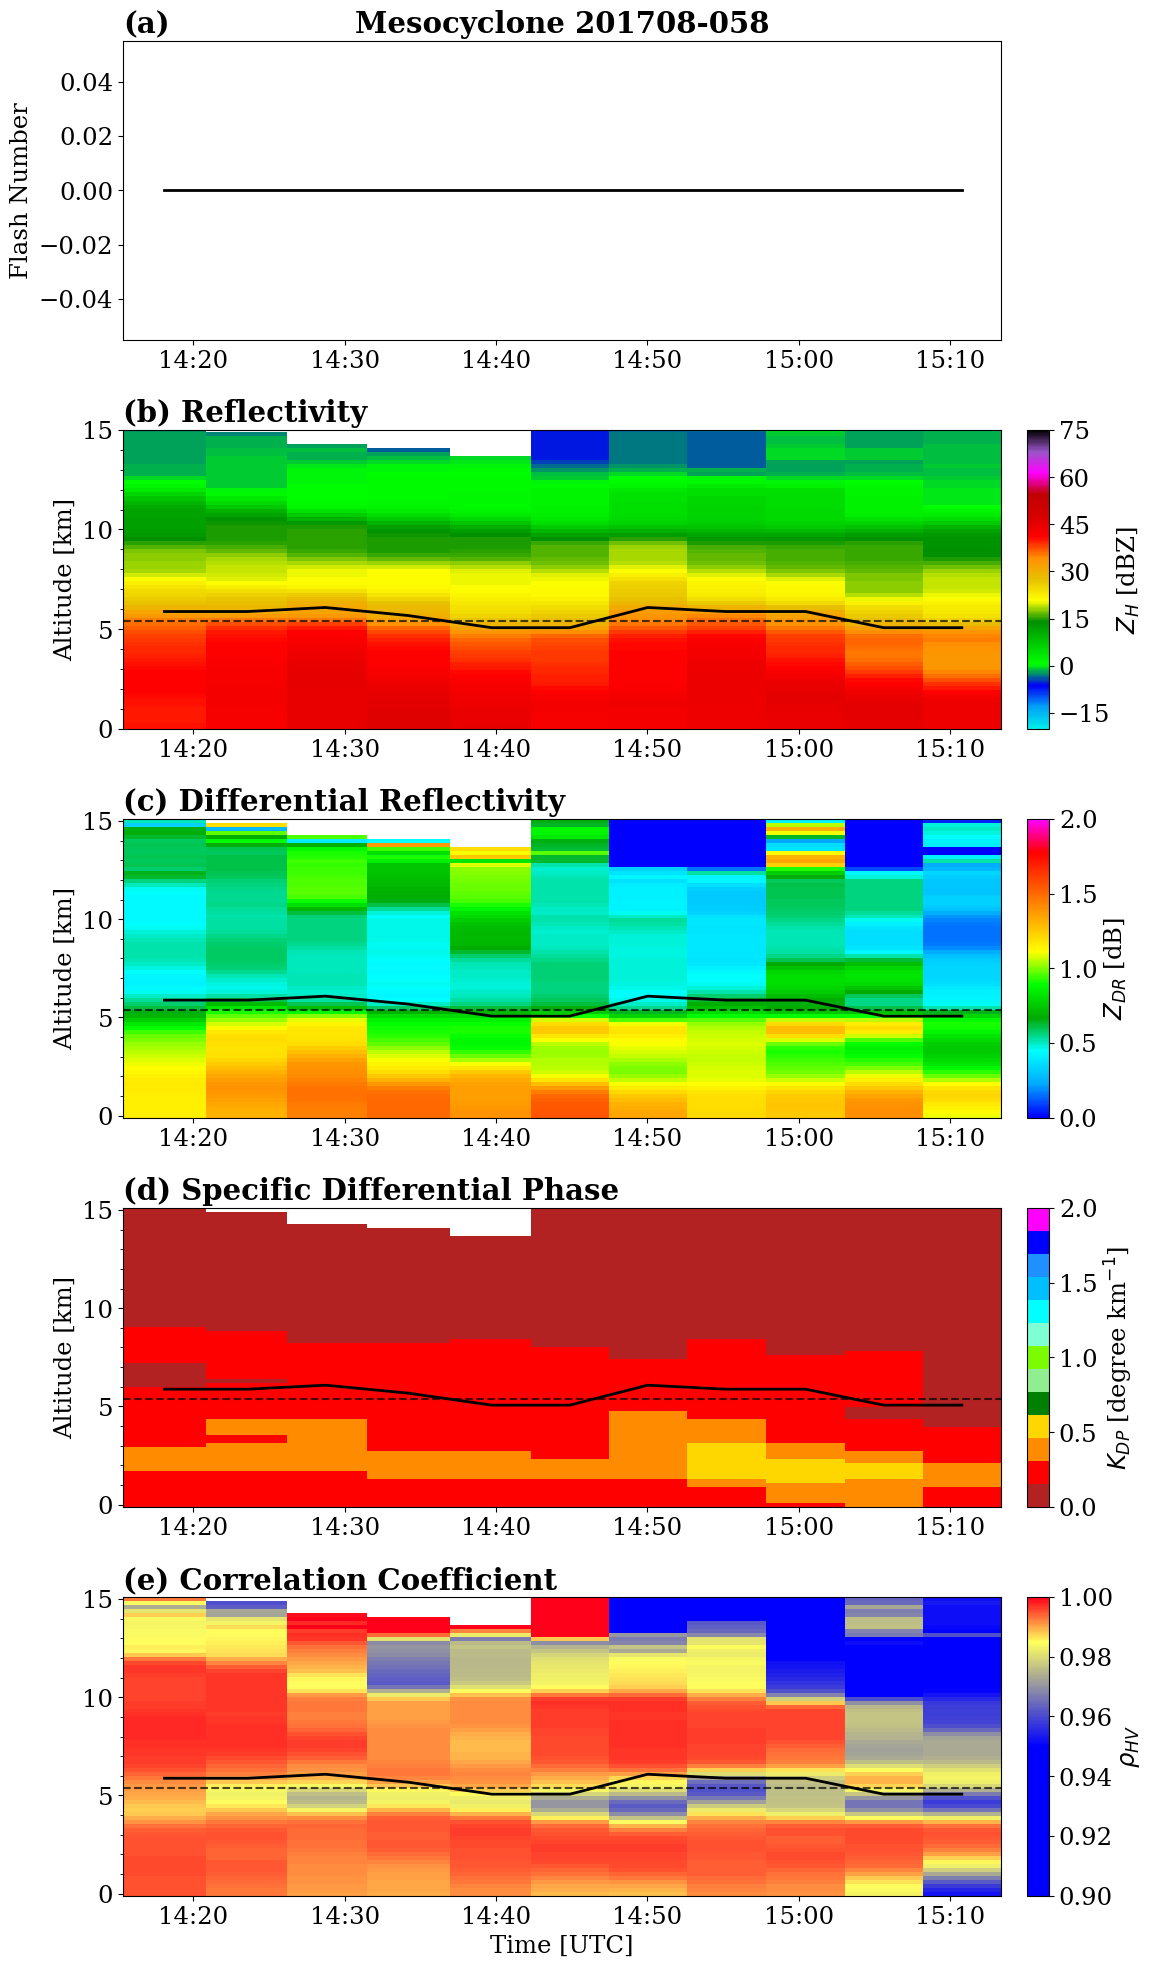

In [36]:
# Create a 2x2 grid for the subplots
fig = plt.figure(figsize=(12, 20))
gs = GridSpec(5, 2, width_ratios=[1, 0.025])

# flash rate time series
ax1 = plt.subplot(gs[0, 0])
ax1.plot(time, case_meso.flash_number, c="black", lw=2)
ax1.set_ylabel("Flash Number")
ax1.set_title(f"Mesocyclone {th.mesocyclone_id}", loc="center")
ax1.set_title("(a)", loc="left")

# reflectivity time-height and depth time series
ax2 = plt.subplot(gs[1, 0], sharex=ax1)
cax2 = plt.subplot(gs[1, 1])
pcm2 = ax2.pcolormesh(time, z/1000, reflectivity.T, cmap="pyart_NWSRef", vmin=-20, vmax=75)
cb = plt.colorbar(pcm2, cax=cax2, label='$Z_H$ [dBZ]')
cb.set_ticks(MultipleLocator(15))
ax2.plot(time, updraft_depth/1000, c="black", lw=2)
ax2.set_ylabel("Altitude [km]")
ax2.set_ylim(0,15)
ax2.set_title("(b) Reflectivity", loc="left")
ax2.axhline(y=melting_layer, ls="--", c="black", lw=1.5, alpha=0.7)
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(1))

# differential reflectivity
ax3 = plt.subplot(gs[2,0], sharex=ax1)
cax3 = plt.subplot(gs[2,1])
pcm3 = ax3.pcolormesh(time, z/1000, differential_reflectivity.T, cmap="pyart_RefDiff", vmin=0, vmax=2)
cb = plt.colorbar(pcm3, cax=cax3, label="$Z_{DR}$ [dB]")
cb.set_ticks(MultipleLocator(0.5))
ax3.set_ylabel("Altitude [km]")
ax3.set_title("(c) Differential Reflectivity", loc="left")
ax3.axhline(y=melting_layer, ls="--", c="black", lw=1.5, alpha=0.7)
ax3.yaxis.set_major_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(1))
ax3.plot(time, updraft_depth/1000, c="black", lw=2)

# Kdp
ax4 = plt.subplot(gs[3,0], sharex=ax1)
cax4 = plt.subplot(gs[3,1])
pcm4 = ax4.pcolormesh(time, z/1000, specific_differential_phase.T, cmap=cmap_kdp, vmin=0, vmax=2)
cb = plt.colorbar(pcm4, cax=cax4, label="$K_{DP}$ [degree km$^{-1}$]")
ax4.set_ylabel("Altitude [km]")
ax4.set_title("(d) Specific Differential Phase", loc="left")
ax4.axhline(y=melting_layer, ls="--", c="black", lw=1.5, alpha=0.7)
ax4.yaxis.set_major_locator(MultipleLocator(5))
ax4.yaxis.set_minor_locator(MultipleLocator(1))
ax4.plot(time, updraft_depth/1000, c="black", lw=2)

# correlation coefficient
ax5 = plt.subplot(gs[4,0], sharex=ax1)
cax5 = plt.subplot(gs[4,1])
pcm5 = ax5.pcolormesh(time, z/1000, cross_correlation_ratio.T, cmap=cc_cmap, vmin=0.90, vmax=1)
cb = plt.colorbar(pcm5, cax=cax5, label="$\\rho_{HV}$")
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax5.set_xlabel("Time [UTC]")
ax5.set_title("(e) Correlation Coefficient", loc="left")
ax5.axhline(y=melting_layer, ls="--", c="black", lw=1.5, alpha=0.7)
ax5.yaxis.set_major_locator(MultipleLocator(5))
ax5.yaxis.set_minor_locator(MultipleLocator(1))
ax5.plot(time, updraft_depth/1000, c="black", lw=2)

plt.tight_layout()
fsave = f"{figdir}timeheight.png"
plt.savefig(fsave, format="png", dpi=300, bbox_inches="tight")